# Text classification with CNN and RNN

We apply CNN and RNN to IMDB database, which includes 50,000 movie reviews, to do text classification. We construct different CNN and RNN structures, even we explore mix CNN-RNN model.Then all these results are compared to classical machine learning algorithms, naive bayes and SVM. we explore the influence of overfitting and regularization. 

## Import database


In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [3]:
word_index=imdb.get_word_index()

In [4]:
# # Convert .bin to .txt, read only 300000 top words

# from gensim.models.keyedvectors import KeyedVectors

# convert = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True,limit=300000)
# convert.save_word2vec_format('GoogleNews-vectors-negative300.txt', binary=False)

Every interger represents one words in the vocabulary.

**Transfer integer to words**

In [115]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
def save_history(history,model_name):
   #history: fit history
   # model_name:String, to generate a csv file to save the history
    import pandas as pd
    history_crnn=pd.DataFrame({'acc_train':history.history["acc"],'acc_val':history.history["val_acc"],
                                       'loss_train':history.history["loss"],'loss_val':history.history["val_loss"]
                         
                          })
    history_crnn.to_csv(model_name+'.csv')

## Data preprocessing

* pad the every sentence to uniform length
* use pre_trained glove data to represent the sentences


In [6]:
#model_list includes every models and how to generate embedding layer
import model_list

Using TensorFlow backend.


In [7]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [8]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [9]:
vocab_size=10000
embedding_size=300
max_length=256

In [10]:
#get embedding layer, default is use golve representation
embedding_layer=model_list.get_embedding_layer(word_index,USE_PRE=1,vocab_size=10000,embedding_size=300,max_length=256)

## CNN part

### Text CNN
[Reference Blog](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/)

[Reference Paper](https://arxiv.org/abs/1408.5882)

In [11]:
text_cnn_model=model_list.text_cnn(embedding_layer)

In [12]:
print(text_cnn_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 256, 256)     230656      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 256, 256)     307456      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [13]:
history_text_cnn = text_cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 17s 1ms/step - loss: 0.5940 - acc: 0.6941 - val_loss: 0.3937 - val_acc: 0.8294
Epoch 2/20
15000/15000 [==============================] - 15s 1ms/step - loss: 0.3034 - acc: 0.8779 - val_loss: 0.3897 - val_acc: 0.8281
Epoch 3/20
15000/15000 [==============================] - 15s 1ms/step - loss: 0.1842 - acc: 0.9375 - val_loss: 0.3993 - val_acc: 0.8309
Epoch 4/20
15000/15000 [==============================] - 15s 1ms/step - loss: 0.0947 - acc: 0.9777 - val_loss: 0.3653 - val_acc: 0.8501
Epoch 5/20
15000/15000 [==============================] - 15s 1ms/step - loss: 0.0406 - acc: 0.9963 - val_loss: 0.4039 - val_acc: 0.8482
Epoch 6/20
15000/15000 [==============================] - 15s 1ms/step - loss: 0.0184 - acc: 0.9994 - val_loss: 0.4456 - val_acc: 0.8425
Epoch 7/20
15000/15000 [==============================] - 15s 1ms/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.4492 - val_acc

In [54]:
save_history(history_text_cnn,'history_text_cnn'+'_glv')

In [61]:
loss_,accuracy_=text_cnn_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 11s 424us/step
The loss on validation set is 0.572930, accuracy is 0.848160


### Channel CNN

In [15]:
filter_sizes=[3,4,5]
feature_maps    = [100,100,100]
hidden_units=100
dropout_rate=.3

In [16]:
channel_cnn_model=model_list.Channel_cnn(embedding_layer,filter_sizes,feature_maps)

In [17]:
print(channel_cnn_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     word_input[0][0]                 
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 300)     0           embedding_1[1][0]                
__________________________________________________________________________________________________
separable_conv1d_1 (SeparableCo (None, 256, 100)     123700      dropout_2[0][0]                  
__________________________________________________________________________________________________
separable_

In [18]:
history_channel_cnn = channel_cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 27s 2ms/step - loss: 0.5552 - acc: 0.7132 - val_loss: 0.4092 - val_acc: 0.8148
Epoch 2/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.3508 - acc: 0.8503 - val_loss: 0.3228 - val_acc: 0.8639
Epoch 3/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.2991 - acc: 0.8743 - val_loss: 0.3029 - val_acc: 0.8736
Epoch 4/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.2655 - acc: 0.8902 - val_loss: 0.2906 - val_acc: 0.8809
Epoch 5/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.2302 - acc: 0.9067 - val_loss: 0.2910 - val_acc: 0.8799
Epoch 6/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.1861 - acc: 0.9290 - val_loss: 0.2822 - val_acc: 0.8878
Epoch 7/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.1650 - acc: 0.9363 - val_loss: 0.3039 - val_acc

In [55]:
save_history(history_channel_cnn,'history_channel_cnn'+'_glv' )

In [62]:
loss_,accuracy_=channel_cnn_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 12s 467us/step
The loss on validation set is 0.499136, accuracy is 0.879320


## LSTM

[Understanding LSTM Network](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)


In [20]:
LSTM_model=model_list.single_LSTM(embedding_layer,cell_num=100,dropout_rate=0.2,recurrent_dropout_rate=0.1)

In [21]:
print(LSTM_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 300)          3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 3,160,501
Trainable params: 160,501
Non-trainable params: 3,000,000
_________________________________________________________________
None


In [22]:
history_LSTM_model = LSTM_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 84s 6ms/step - loss: 0.6766 - acc: 0.5617 - val_loss: 0.6698 - val_acc: 0.5972
Epoch 2/20
15000/15000 [==============================] - 76s 5ms/step - loss: 0.6794 - acc: 0.5546 - val_loss: 0.6603 - val_acc: 0.5693
Epoch 3/20
15000/15000 [==============================] - 76s 5ms/step - loss: 0.6856 - acc: 0.5475 - val_loss: 0.6876 - val_acc: 0.5278
Epoch 4/20
15000/15000 [==============================] - 76s 5ms/step - loss: 0.6778 - acc: 0.5461 - val_loss: 0.6719 - val_acc: 0.5517
Epoch 5/20
15000/15000 [==============================] - 71s 5ms/step - loss: 0.6778 - acc: 0.5389 - val_loss: 0.6810 - val_acc: 0.5348
Epoch 6/20
15000/15000 [==============================] - 70s 5ms/step - loss: 0.6713 - acc: 0.5487 - val_loss: 0.6664 - val_acc: 0.5571
Epoch 7/20
15000/15000 [==============================] - 71s 5ms/step - loss: 0.6345 - acc: 0.6119 - val_loss: 0.5236 - val_acc

In [56]:
save_history(history_LSTM_model,'history_LSTM_model'+'_glv' )

In [63]:
loss_,accuracy_=LSTM_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 147s 6ms/step
The loss on validation set is 0.283717, accuracy is 0.880640


## Bi-GRU (take a long time)
[Recurrent Neural Network for Text Classification with Multi-Task Learning](https://www.ijcai.org/Proceedings/16/Papers/408.pdf)

In [24]:
# Bi_GRU_model=model_list.Bi_GRU(embedding_layer,cell_num=128,dropout_rate=0.2,recurrent_dropout_rate=0.1)

In [ ]:
# print(Bi_GRU_model.summary())

In [ ]:
# history_Bi_GRU_model = Bi_GRU_model.fit(partial_x_train,
#                     partial_y_train,
#                     epochs=6,
#                     batch_size=256,
#                     validation_data=(x_val, y_val),
#                     verbose=1)

In [ ]:
# save_history(history_Bi_GRU_model,'history_Bi_GRU_model' )

## C_GRU_Series

[A C-LSTM Neural Network for Text Classification](https://arxiv.org/abs/1511.08630)

In [27]:
C_GRU_series_model=model_list.C_RNN_series(embedding_layer)

In [28]:
print(C_GRU_series_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 300)          3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 256, 128)          115328    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 128, 128)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128, 128)          98688     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 3,312,833
Trainable params: 312,833
Non-trainable params: 3,000,000
____________________________________________________________

In [29]:
history_C_GRU_series_model= C_GRU_series_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 67s 4ms/step - loss: 0.6757 - acc: 0.5549 - val_loss: 0.6962 - val_acc: 0.5106
Epoch 2/20
15000/15000 [==============================] - 64s 4ms/step - loss: 0.6552 - acc: 0.5692 - val_loss: 0.6151 - val_acc: 0.6050
Epoch 3/20
15000/15000 [==============================] - 64s 4ms/step - loss: 0.4992 - acc: 0.7658 - val_loss: 0.4226 - val_acc: 0.8213
Epoch 4/20
15000/15000 [==============================] - 66s 4ms/step - loss: 0.5035 - acc: 0.7547 - val_loss: 0.3650 - val_acc: 0.8430
Epoch 5/20
15000/15000 [==============================] - 66s 4ms/step - loss: 0.3801 - acc: 0.8354 - val_loss: 0.3388 - val_acc: 0.8541
Epoch 6/20
15000/15000 [==============================] - 66s 4ms/step - loss: 0.3386 - acc: 0.8565 - val_loss: 0.3164 - val_acc: 0.8662
Epoch 7/20
15000/15000 [==============================] - 66s 4ms/step - loss: 0.3093 - acc: 0.8694 - val_loss: 0.3958 - val_acc

In [57]:
save_history(history_C_GRU_series_model,'history_C_GRU_series_model'+'_glv' )

In [66]:
loss_,accuracy_=C_GRU_series_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 135s 5ms/step
The loss on validation set is 0.424946, accuracy is 0.871600


## C_GRU_Parallel 

No reference paper

In [31]:
C_RNN_Parallel_model=model_list.C_RNN_Parallel(embedding_layer)

In [32]:
print(C_RNN_Parallel_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 256, 256)     230656      embedding_1[5][0]                
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 64, 256)      0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
flatten_2 

In [34]:
history_C_RNN_Parallel_model= C_RNN_Parallel_model.fit(partial_x_train,#very slow
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 74s 5ms/step - loss: 0.2704 - acc: 0.8943 - val_loss: 0.3659 - val_acc: 0.8438
Epoch 2/20
15000/15000 [==============================] - 75s 5ms/step - loss: 0.1690 - acc: 0.9412 - val_loss: 0.3973 - val_acc: 0.8403
Epoch 3/20
15000/15000 [==============================] - 74s 5ms/step - loss: 0.0818 - acc: 0.9782 - val_loss: 0.4612 - val_acc: 0.8416
Epoch 4/20
15000/15000 [==============================] - 75s 5ms/step - loss: 0.0266 - acc: 0.9953 - val_loss: 0.5366 - val_acc: 0.8369
Epoch 5/20
15000/15000 [==============================] - 74s 5ms/step - loss: 0.0088 - acc: 0.9997 - val_loss: 0.5951 - val_acc: 0.8404
Epoch 6/20
15000/15000 [==============================] - 76s 5ms/step - loss: 0.0034 - acc: 0.9999 - val_loss: 0.6385 - val_acc: 0.8392
Epoch 7/20
15000/15000 [==============================] - 75s 5ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.6664 - val_acc

In [58]:
save_history(history_C_RNN_Parallel_model,'history_C_RNN_Parallel_model'+'_glv' )

In [64]:
loss_,accuracy_=C_RNN_Parallel_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 177s 7ms/step
The loss on validation set is 0.836123, accuracy is 0.833640


## Visulization

In [36]:
#matplotlib inline
import matplotlib.pyplot as plt

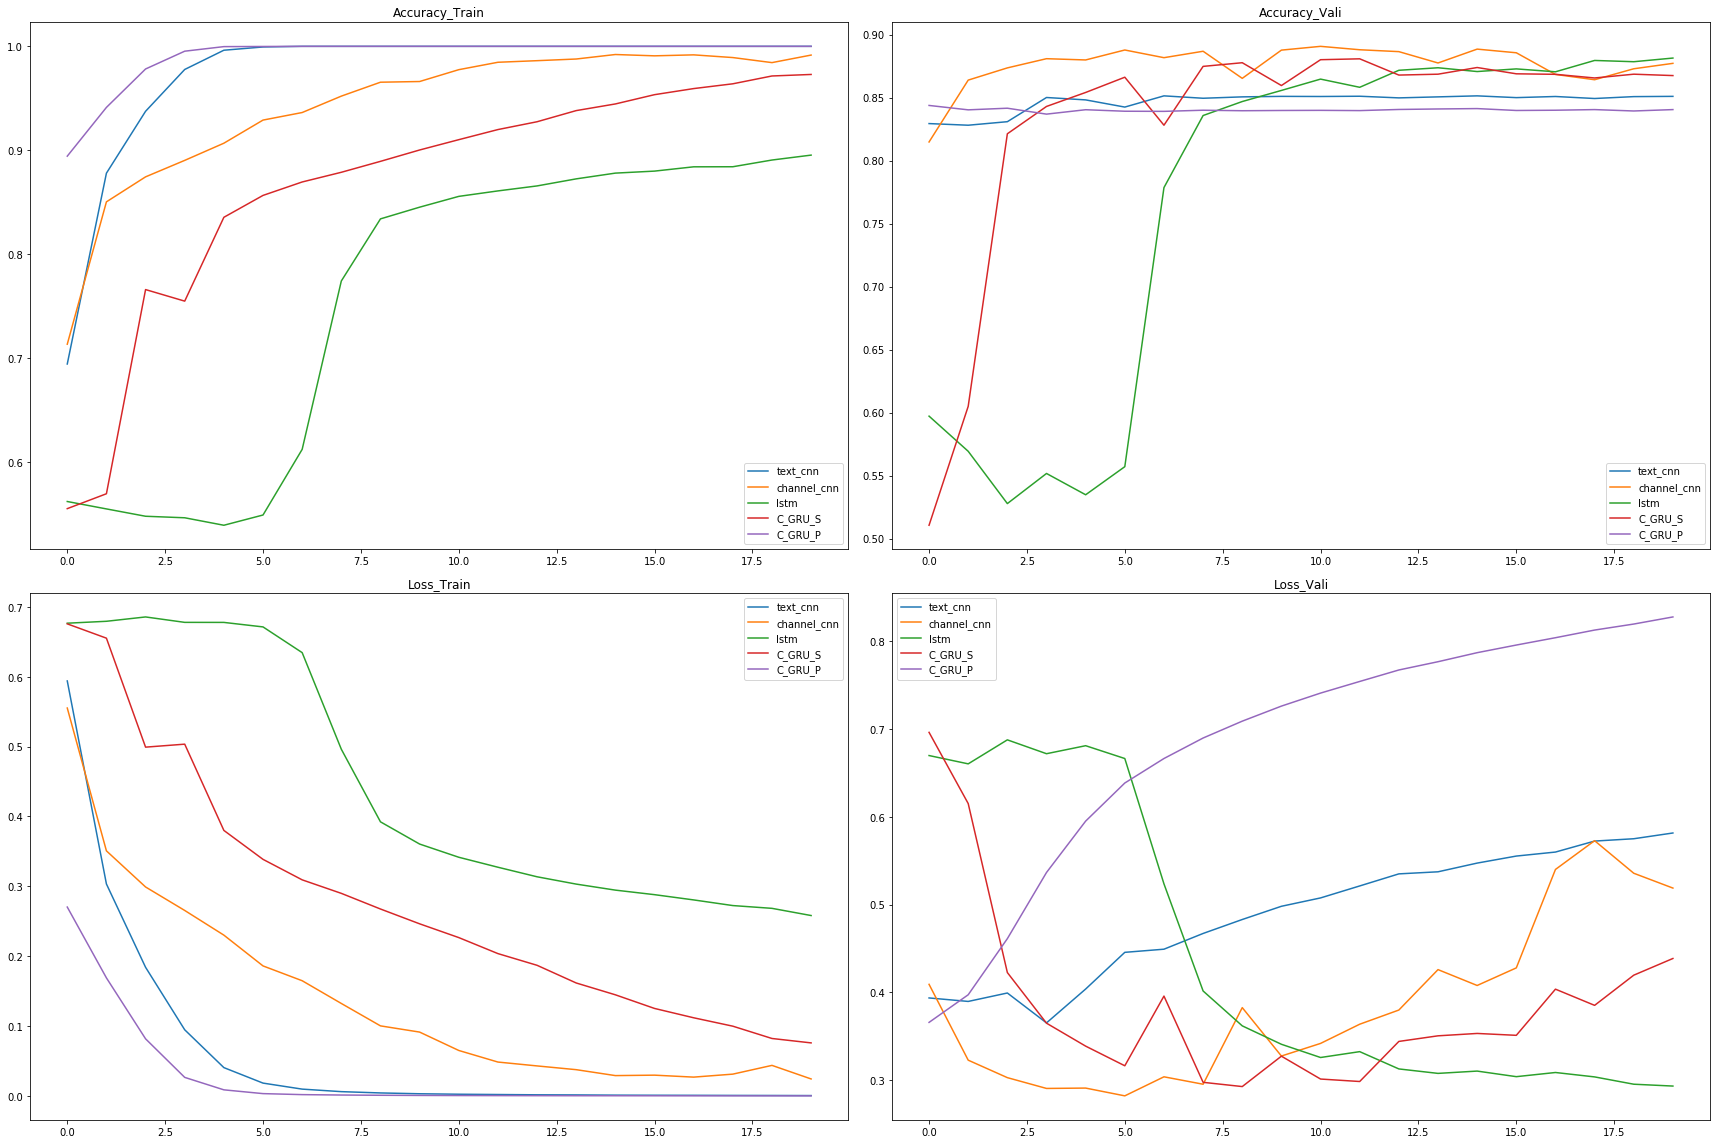

In [130]:
plt.figure(figsize=[24,16]) 
plt.subplot(221)
plt.title('Accuracy_Train')
plt.plot(history_text_cnn.history['acc'],label='text_cnn')
plt.plot(history_channel_cnn.history['acc'],label='channel_cnn')
# plt.plot(history_Bi_GRU_model.history['acc'],label='Bi_GRU')
plt.plot(history_LSTM_model.history['acc'],label='lstm')
plt.plot(history_C_GRU_series_model.history['acc'],label='C_GRU_S')
plt.plot(history_C_RNN_Parallel_model.history['acc'],label='C_GRU_P')
plt.legend(loc='best')

plt.subplot(222)
plt.title('Accuracy_Vali')
plt.plot(history_text_cnn.history['val_acc'],label='text_cnn')
plt.plot(history_channel_cnn.history['val_acc'],label='channel_cnn')
# plt.plot(history_Bi_GRU_model.history['val_acc'],label='Bi_GRU')
plt.plot(history_LSTM_model.history['val_acc'],label='lstm')
plt.plot(history_C_GRU_series_model.history['val_acc'],label='C_GRU_S')
plt.plot(history_C_RNN_Parallel_model.history['val_acc'],label='C_GRU_P')
plt.legend(loc='best')

plt.subplot(223)
plt.title('Loss_Train')
plt.plot(history_text_cnn.history['loss'],label='text_cnn')
plt.plot(history_channel_cnn.history['loss'],label='channel_cnn')
# plt.plot(history_Bi_GRU_model.history['loss'],label='Bi_GRU')
plt.plot(history_LSTM_model.history['loss'],label='lstm')
plt.plot(history_C_GRU_series_model.history['loss'],label='C_GRU_S')
plt.plot(history_C_RNN_Parallel_model.history['loss'],label='C_GRU_P')
plt.legend(loc='best')

plt.subplot(224)
plt.title('Loss_Vali')
plt.plot(history_text_cnn.history['val_loss'],label='text_cnn')
plt.plot(history_channel_cnn.history['val_loss'],label='channel_cnn')
# plt.plot(history_Bi_GRU_model.history['val_loss'],label='Bi_GRU')
plt.plot(history_LSTM_model.history['val_loss'],label='lstm')
plt.plot(history_C_GRU_series_model.history['val_loss'],label='C_GRU_S')
plt.plot(history_C_RNN_Parallel_model.history['val_loss'],label='C_GRU_P')
plt.legend(loc='best')
plt.savefig('all_models'+'_glv')
plt.tight_layout()
plt.show()


## regularization

### regularizer.l2

In [67]:
C_GRU_series_model_reg=model_list.C_RNN_series2(embedding_layer,reg_coef=0.01)

In [68]:
print(C_GRU_series_model_reg.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 300)          3000000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 256, 128)          115328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256, 128)          0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 128, 128)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 128, 128)          98688     
_________________________________________________________________
gru_8 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total para

In [69]:
history_C_GRU_series_model_reg= C_GRU_series_model_reg.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 40s 3ms/step - loss: 1.3047 - acc: 0.5291 - val_loss: 0.7415 - val_acc: 0.5665
Epoch 2/20
15000/15000 [==============================] - 36s 2ms/step - loss: 0.7039 - acc: 0.5696 - val_loss: 0.6690 - val_acc: 0.5854
Epoch 3/20
15000/15000 [==============================] - 36s 2ms/step - loss: 0.6671 - acc: 0.6215 - val_loss: 0.5167 - val_acc: 0.8174
Epoch 4/20
15000/15000 [==============================] - 35s 2ms/step - loss: 0.5559 - acc: 0.7829 - val_loss: 0.5707 - val_acc: 0.7816
Epoch 5/20
15000/15000 [==============================] - 36s 2ms/step - loss: 0.5290 - acc: 0.7991 - val_loss: 0.4805 - val_acc: 0.8305
Epoch 6/20
15000/15000 [==============================] - 36s 2ms/step - loss: 0.5750 - acc: 0.7657 - val_loss: 0.5577 - val_acc: 0.7930
Epoch 7/20
15000/15000 [==============================] - 36s 2ms/step - loss: 0.5259 - acc: 0.8023 - val_loss: 0.4429 - val_acc

In [70]:
save_history(history_C_GRU_series_model_reg,'history_C_GRU_series_model_reg'+'_glv' )

In [71]:
loss_,accuracy_=C_GRU_series_model_reg.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 139s 6ms/step
The loss on validation set is 0.439719, accuracy is 0.856040


### dropout

In [39]:
C_RNN_Parallel_model_dropout=model_list.C_RNN_Parallel2(embedding_layer,dropout_rate_conv=0.4)

In [40]:
print(C_RNN_Parallel_model_dropout.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 256, 256)     230656      embedding_1[6][0]                
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 256, 256)     0           conv1d_6[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [41]:
history_C_RNN_Parallel_model_dropout= C_RNN_Parallel_model_dropout.fit(partial_x_train,#very slow
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 78s 5ms/step - loss: 1.8752 - acc: 0.6127 - val_loss: 0.4575 - val_acc: 0.7943
Epoch 2/20
15000/15000 [==============================] - 80s 5ms/step - loss: 0.4053 - acc: 0.8219 - val_loss: 0.3817 - val_acc: 0.8371
Epoch 3/20
15000/15000 [==============================] - 81s 5ms/step - loss: 0.3123 - acc: 0.8689 - val_loss: 0.3731 - val_acc: 0.8390
Epoch 4/20
15000/15000 [==============================] - 81s 5ms/step - loss: 0.2435 - acc: 0.9033 - val_loss: 0.3706 - val_acc: 0.8446
Epoch 5/20
15000/15000 [==============================] - 82s 5ms/step - loss: 0.1858 - acc: 0.9293 - val_loss: 0.4568 - val_acc: 0.8177
Epoch 6/20
15000/15000 [==============================] - 85s 6ms/step - loss: 0.1202 - acc: 0.9579 - val_loss: 0.4235 - val_acc: 0.8432
Epoch 7/20
15000/15000 [==============================] - 83s 6ms/step - loss: 0.0754 - acc: 0.9753 - val_loss: 0.4844 - val_acc

In [60]:
save_history(history_C_RNN_Parallel_model_dropout,'history_C_RNN_Parallel_model_dropout'+'_glv' )

In [65]:
loss_,accuracy_=C_RNN_Parallel_model_dropout.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 183s 7ms/step
The loss on validation set is 0.761494, accuracy is 0.843520


## Visualization

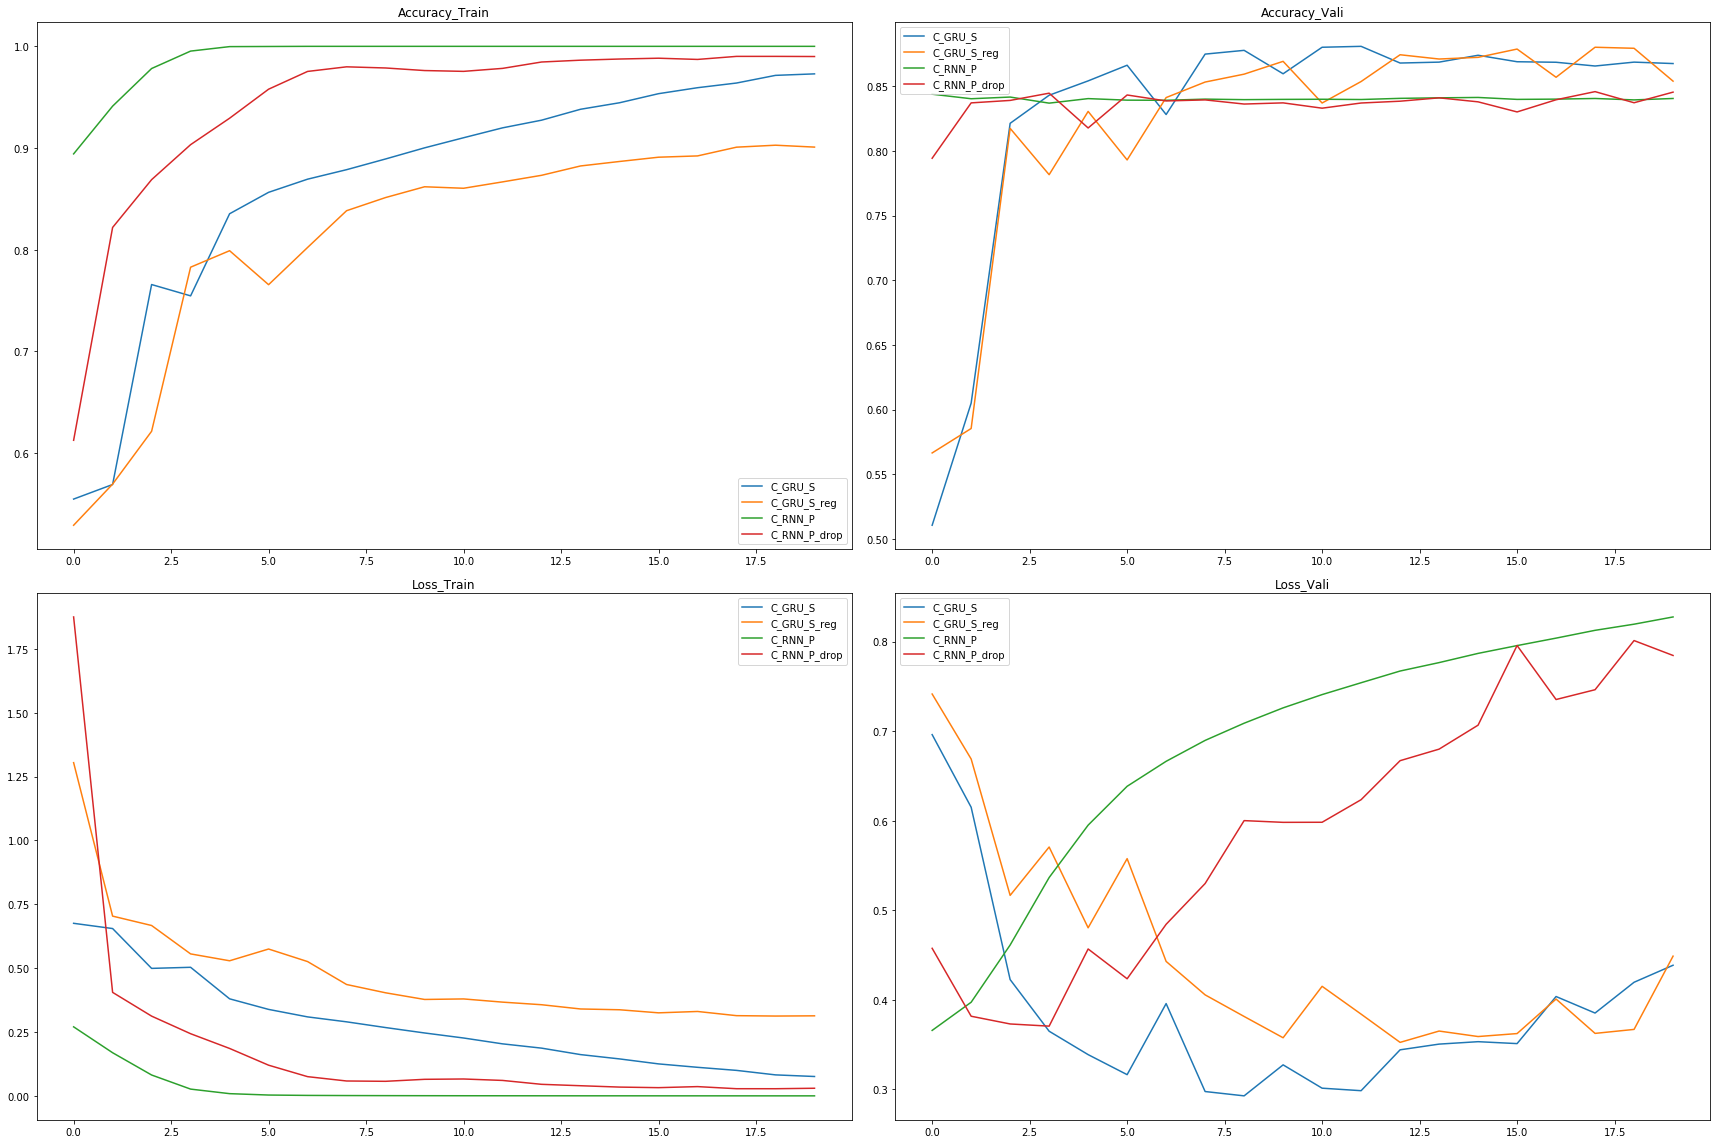

In [131]:
plt.figure(figsize=[24,16])

plt.subplot(221)
plt.title('Accuracy_Train')
plt.plot(history_C_GRU_series_model.history['acc'],label='C_GRU_S')
plt.plot(history_C_GRU_series_model_reg.history['acc'],label='C_GRU_S_reg')
plt.plot(history_C_RNN_Parallel_model.history['acc'],label='C_RNN_P')
plt.plot(history_C_RNN_Parallel_model_dropout.history['acc'],label='C_RNN_P_drop')
plt.legend(loc='best')

plt.subplot(222)
plt.title('Accuracy_Vali')
plt.plot(history_C_GRU_series_model.history['val_acc'],label='C_GRU_S')
plt.plot(history_C_GRU_series_model_reg.history['val_acc'],label='C_GRU_S_reg')
plt.plot(history_C_RNN_Parallel_model.history['val_acc'],label='C_RNN_P')
plt.plot(history_C_RNN_Parallel_model_dropout.history['val_acc'],label='C_RNN_P_drop')
plt.legend(loc='best')

plt.subplot(223)
plt.title('Loss_Train')
plt.plot(history_C_GRU_series_model.history['loss'],label='C_GRU_S')
plt.plot(history_C_GRU_series_model_reg.history['loss'],label='C_GRU_S_reg')
plt.plot(history_C_RNN_Parallel_model.history['loss'],label='C_RNN_P')
plt.plot(history_C_RNN_Parallel_model_dropout.history['loss'],label='C_RNN_P_drop')
plt.legend(loc='best')

plt.subplot(224)
plt.title('Loss_Vali')
plt.plot(history_C_GRU_series_model.history['val_loss'],label='C_GRU_S')
plt.plot(history_C_GRU_series_model_reg.history['val_loss'],label='C_GRU_S_reg')
plt.plot(history_C_RNN_Parallel_model.history['val_loss'],label='C_RNN_P')
plt.plot(history_C_RNN_Parallel_model_dropout.history['val_loss'],label='C_RNN_P_drop')
plt.legend(loc='best')
plt.savefig('reg_and_drop'+'_glv'+'.png')
plt.tight_layout()
plt.show()
